In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import cv2

# Importing the datasets 

In [2]:
training_file = "train.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

## Dataset facts 

In [3]:
n_train = len(y_train)
n_test = len(y_test)
image_shape  = np.shape(X_train[1])
n_classes = len(np.unique(y_train))

img_size_flat = image_shape[0] * image_shape[1]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

print("Image Size Flat =", img_size_flat)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image Size Flat = 1024


# One-hot encoding the labels

In [4]:
y_train_encoded = np.eye(43)[y_train]
y_test_encoded = np.eye(43)[y_test]

In [5]:
image_shape[0]

32

In [6]:
np.min(X_train)

0

# Pre-processing the images


In [7]:
def pre_process_image(image):
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.resize(image, (32,32),interpolation = cv2.INTER_CUBIC)
    
    #Min-Max scaling for greyscale image data
#     Xmin = 0
#     Xmax = 255
#     a = 0.1
#     b = 0.9
    
#     image = a + ((image - Xmin) * (b-a)) / (Xmax-Xmin)
    return image

In [8]:
image_GS_train = np.array([pre_process_image(X_train[i]) for i in range(len(X_train))], dtype = np.float32)
image_GS_test = np.array([pre_process_image(X_test[i]) for i in range(len(X_test))], dtype = np.float32)

In [9]:
image_flat_train = image_GS_train.reshape((-1,img_size_flat))
image_flat_test  = image_GS_test.reshape((-1,img_size_flat))

In [10]:
(image_flat_train[0])

array([ 78.,  76.,  84., ...,  99.,  97.,  94.], dtype=float32)

# Batching

In [11]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(image_flat_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=batch_size,
                           replace=False)

    # Use the random index to select random images and labels.
    features_batch = image_flat_train[idx, :]
    labels_batch = y_train_encoded[idx, :]

    return features_batch, labels_batch

# Setting up the TensorFlow model

## setting up the constants

In [12]:
x = tf.placeholder(tf.float32, [None, img_size_flat])
y = tf.placeholder(tf.float32, [None, n_classes])

# sets up a place for the non one-hot classes to go
y_true_cls = tf.placeholder(tf.int64, [None])

In [13]:
# x_flat = tf.reshape(x, [-1, img_size_flat*3])
# x_flat


## setting up the variables (the things that change -- weights and biases)

In [14]:
weights = tf.Variable(tf.zeros([img_size_flat, n_classes]))
biases = tf.Variable(tf.zeros([n_classes]))


## model hyperparameters

In [38]:
learning_rate = 0.1
# n_iterations = 10001
batch_size = 200
display_step = 100


# TensorFlow model

In [16]:
logits = tf.matmul(x, weights) + biases
y_pred = tf.nn.softmax(logits)
y_pred_cls = tf.argmax(y_pred, dimension = 1)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels= y)
cost = tf.reduce_mean(cross_entropy)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate = learning_rate).minimize(cost)
optimizer = tf.train.AdagradOptimizer(learning_rate = 1e-2).minimize(cost)

correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))





# TensorFlow Session


In [17]:
# start_time = time.time()

# init = tf.initialize_all_variables()

# with tf.Session() as sess: 
# #     sess = tf.Session()
#     sess.run(init)

#     for iteration in range(n_iterations):
# #         total_batch = int(n_train/batch_size)

# #         for batch_i in range(total_batch):

# #             batch_start = batch_i * batch_size
# #             batch_x = image_flat_train[batch_start:batch_start + batch_size]
# #             batch_y = y_train_encoded[batch_start:batch_start + batch_size]
#         features_batch, labels_true_batch = random_batch()
#         feed_dict_batch = {x:features_batch,
#                             y: labels_true_batch}
#         sess.run(optimizer, feed_dict = feed_dict_batch)

      
            
            
#     end_time = time.time()
#     compute_time = end_time - start_time

#     print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))



In [18]:
def optimize(n_iterations):
      for iteration in range(n_iterations):
        features_batch, labels_true_batch = random_batch()
        feed_dict_batch = {x: features_batch, y: labels_true_batch}
        sess.run(optimizer, feed_dict = feed_dict_batch)

In [25]:
sess = tf.Session()


In [39]:
start_time = time.time()
sess.run(tf.initialize_all_variables())

optimize(10000)

end_time = time.time()
compute_time = end_time - start_time

print("compute time: " , str(timedelta(seconds = int(round(compute_time)))))

compute time:  0:00:55


In [44]:
feed_dict_test = {x: image_flat_test,
                  y: y_test_encoded,
                  y_true_cls:y_test}

In [45]:

acc = sess.run(accuracy,feed_dict=feed_dict_test)
print(acc)
    

0.816627



# Predicting the class for one image

helpful source: http://stackoverflow.com/questions/33711556/making-predictions-with-a-tensorflow-model

In [23]:
image_flat_train[0]

array([ 78.,  76.,  84., ...,  99.,  97.,  94.], dtype=float32)

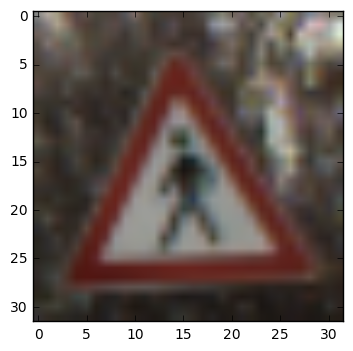

In [55]:
plt.imshow(X_test[10000])

In [52]:
y_test[10000]

27

In [57]:
feed_dict = {x: image_flat_test[9998:10002]}
classification = sess.run(y_pred, feed_dict)
cls = np.argmax(classification, axis=1)
print(cls)

[25  1 27 12]
